#  Deep Convolutional GAN (DCGAN) -MNIST Augmentation

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
from tqdm.auto import trange

## Utilities

In [2]:
def plot_results(images, n_cols=None, title=None):
    
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    
    fig = plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")
        
    plt.suptitle(title)

In [3]:
BATCH_SIZE = 128
CODINGS_SIZE = 32
N_EPOCHS = 150

# Prepare the Dataset

In [4]:
def prepare_data(label, batch_size):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])
    
    X_all = X_all.astype(np.float32) / 255
    X_all = X_all.reshape(-1, 28, 28, 1) * 2. - 1.
    X_train = X_all[np.where(y_all == LABEL)]

    dataset = tf.data.Dataset.from_tensor_slices(X_train)
    dataset = dataset.shuffle(1024)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)
    
    return dataset

def prepare_images(label):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])
    
    X_all = X_all.astype(np.float32) / 255
    X_all = X_all.reshape(-1, 28, 28, 1) * 2. - 1.
    X_train = X_all[np.where(y_all == label)]
    
    return X_train

# Build the Model

In DCGANs, convolutional layers are predominantly used to build the generator and discriminator. You will see how the layers are stacked as well as the best practices shown below.

### Generator

For the generator, we take in random noise and eventually transform it to the shape of the MNIST images. The general steps are:

* Feed the input noise to a dense layer.
* Reshape the output to have three dimensions. This stands for the (length, width, number of filters).
* Perform a deconvolution (with Conv2DTranspose), reducing the number of filters by half and using a stride of `2`.
* The final layer upsamples the features to the size of the training images. In this case 28 x 28 x 1.

Notice that batch normalization is performed except for the final deconvolution layer. As best practice, `selu` is the activation used for the intermediate deconvolution while `tanh` is for the output.

### Discriminator

The discriminator will use strided convolutions to reduce the dimensionality of the input images. As best practice, these are activated by LeakyRELU. The output features will be flattened and fed to a 1-unit dense layer activated by `sigmoid`.

In [5]:
def build_generator():
    inputs = keras.Input(shape=[CODINGS_SIZE])
    x = keras.layers.Dense(7 * 7 * 128)(inputs)
    x = keras.layers.Reshape([7, 7, 128])(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding="SAME", activation="selu")(x)
    x = keras.layers.BatchNormalization()(x)
    skip = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding="SAME", activation="selu")(x)
    skip = keras.layers.BatchNormalization()(skip)
    skip = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding="SAME", activation="selu")(skip)
    skip = keras.layers.BatchNormalization()(skip)
    x = keras.layers.add([x, skip])
    x = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="SAME",activation="selu")(x)
    skip = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding="SAME", activation="selu")(x)
    skip = keras.layers.BatchNormalization()(skip)
    skip = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding="SAME", activation="selu")(skip)
    skip = keras.layers.BatchNormalization()(skip)
    x = keras.layers.add([x, skip])
    outputs = keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME",activation="tanh")(x)
    return keras.models.Model(inputs, outputs, name='generator')

In [6]:
def build_discriminator():
    return keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=3, strides=1, padding="SAME", activation=keras.layers.LeakyReLU(0.2), input_shape=[28, 28, 1]),
    keras.layers.Conv2D(128, kernel_size=3, strides=1, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=3, strides=1, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Conv2D(128, kernel_size=3, strides=1, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
], name='discriminator')

In [7]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator 
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


Generator Summary


Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 6272)         206976      input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 7, 7, 128)    0           dense[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 7, 7, 128)    512         reshape[0][0]                    
______________________________________________________________________

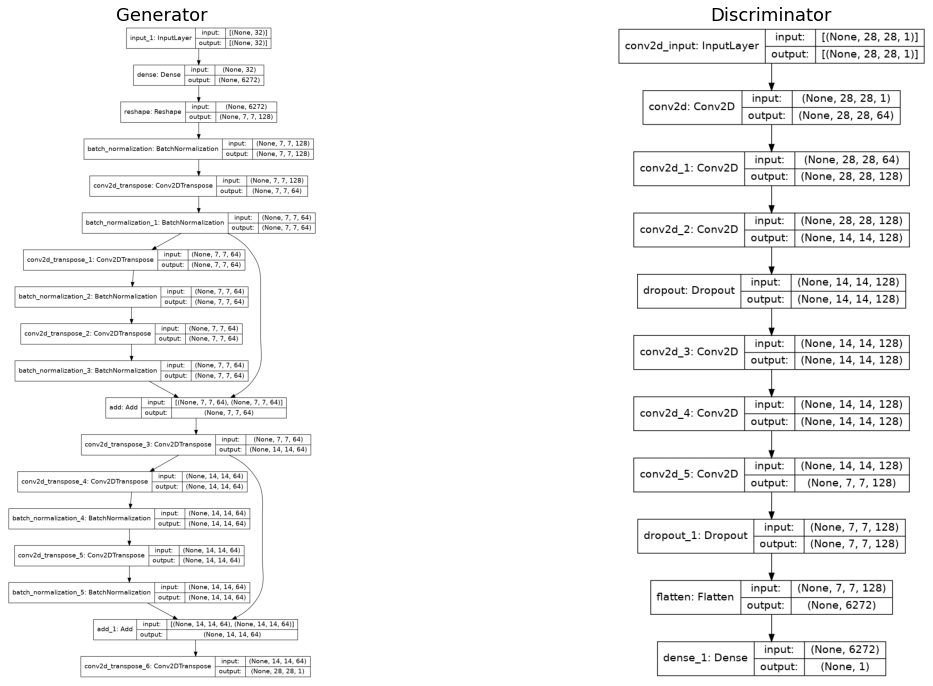

In [8]:
generator = build_generator()
discriminator = build_discriminator()
print('Generator Summary\n\n')
generator.summary()
print('\n\nDiscriminator Summary\n\n')
discriminator.summary()
keras.utils.plot_model(generator, show_shapes=True, expand_nested=True, to_file='generator.png')
keras.utils.plot_model(discriminator, show_shapes=True, expand_nested=True, to_file='discriminator.png')
fig, ax = plt.subplots(1, 2, figsize=(20, 12))
ax[0].imshow(plt.imread('generator.png'))
ax[0].set_title('Generator', fontsize=18)
ax[1].imshow(plt.imread('discriminator.png'))
ax[1].set_title('Discriminator', fontsize=18)
ax[0].axis("off")
ax[1].axis("off")
plt.show()

# GAN in Action

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/150
53/53 [==============================] - 7s 57ms/step - d_loss: 0.4769 - g_loss: 1.3246
Epoch 2/150
53/53 [==============================] - 3s 57ms/step - d_loss: 0.1862 - g_loss: 2.4522
Epoch 3/150
53/53 [==============================] - 3s 57ms/step - d_loss: 0.5739 - g_loss: 1.5468
Epoch 4/150
53/53 [==============================] - 3s 57ms/step - d_loss: 0.3547 - g_loss: 1.8964
Epoch 5/150
53/53 [==============================] - 3s 57ms/step - d_loss: 0.6112 - g_loss: 1.2027
Epoch 6/150
53/53 [==============================] - 3s 57ms/step - d_loss: 0.6348 - g_loss: 1.2208
Epoch 7/150
53/53 [==============================] - 3s 57ms/step - d_loss: 0.4411 - g_loss: 1.7507
Epoch 8/150
53/53 [==============================] - 3s 57ms/step - d_loss: 0.4159 - g_loss: 2.2939
Epoch 9/150
53/53 [==============================] - 3s 56ms/step - d_loss: 0.4990 - g_loss: 1.5534
Epoch 10/150
53/53 [===============

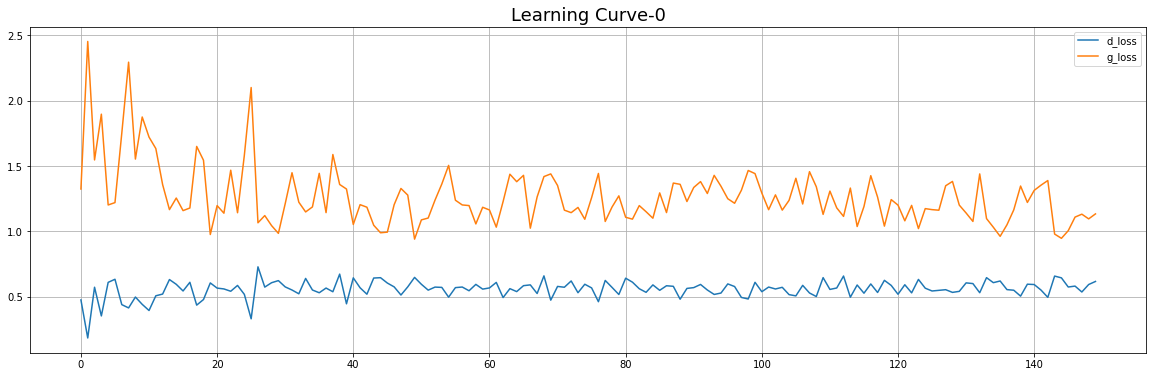

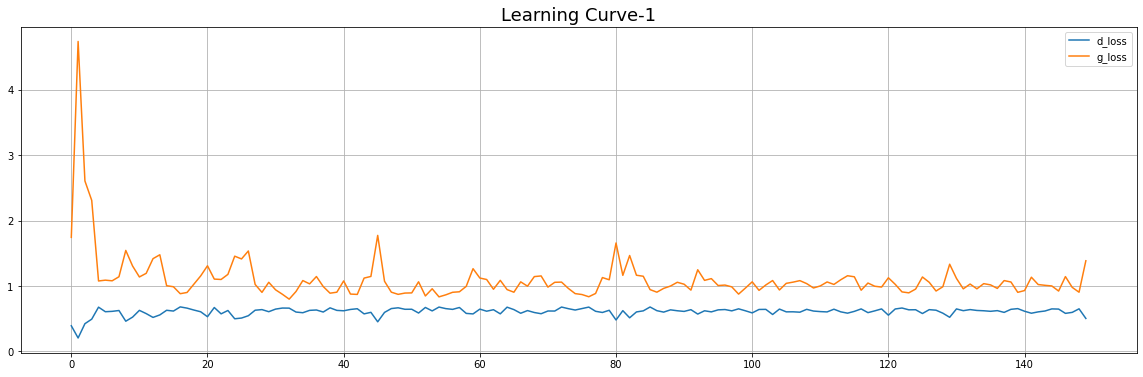

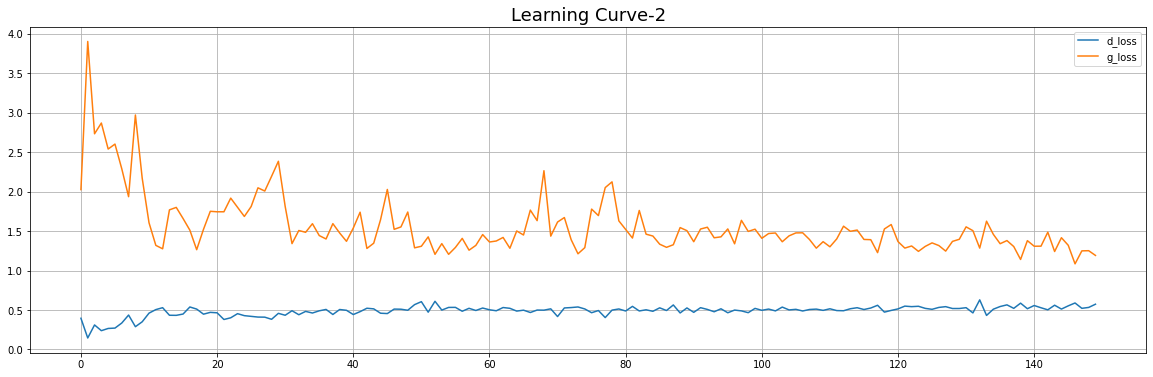

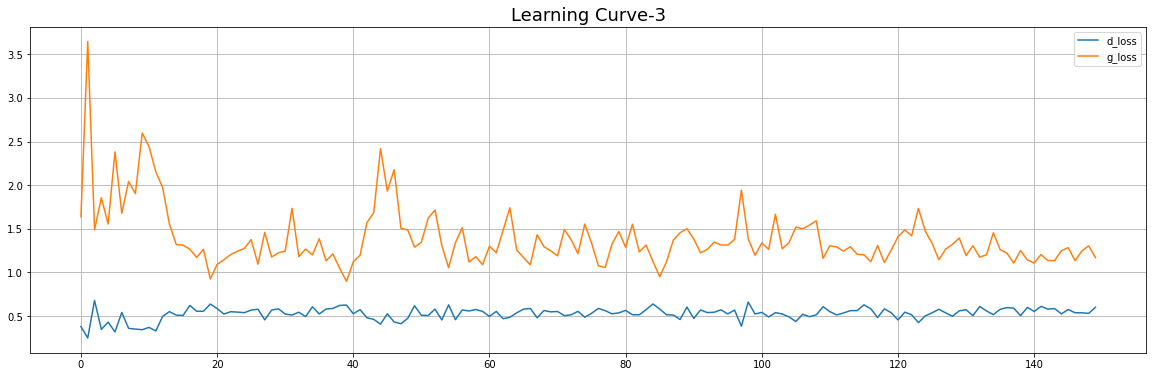

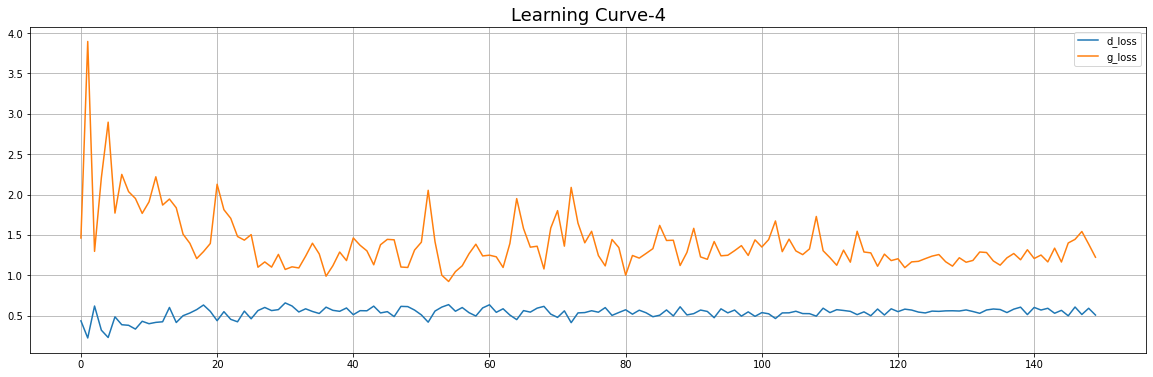

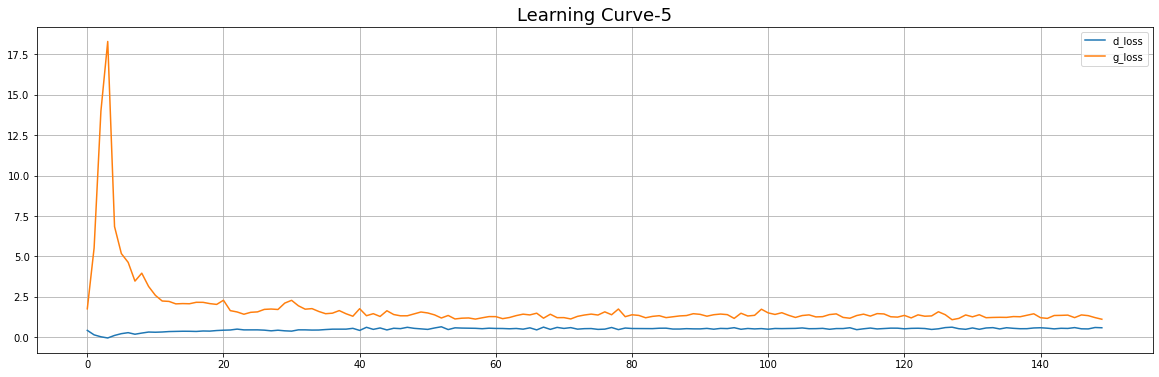

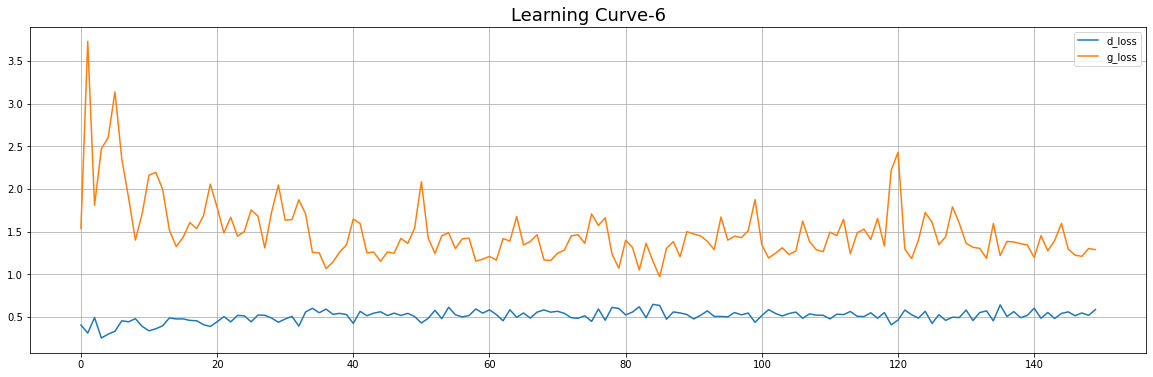

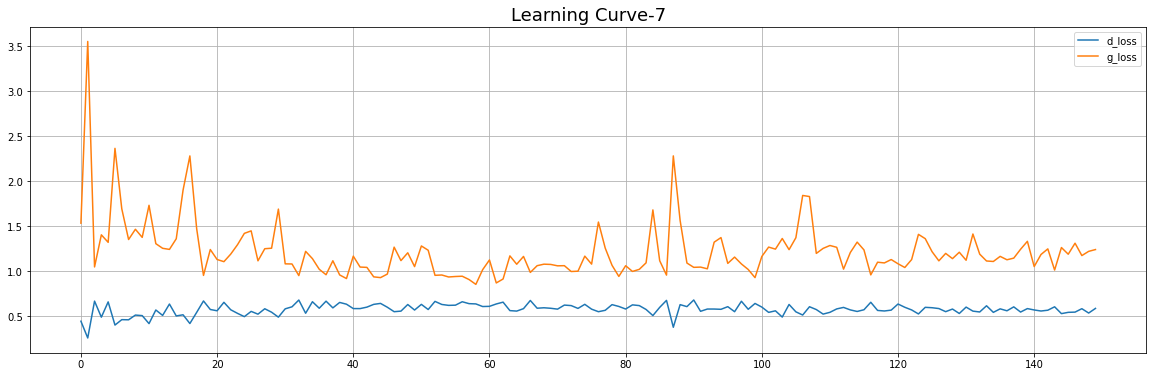

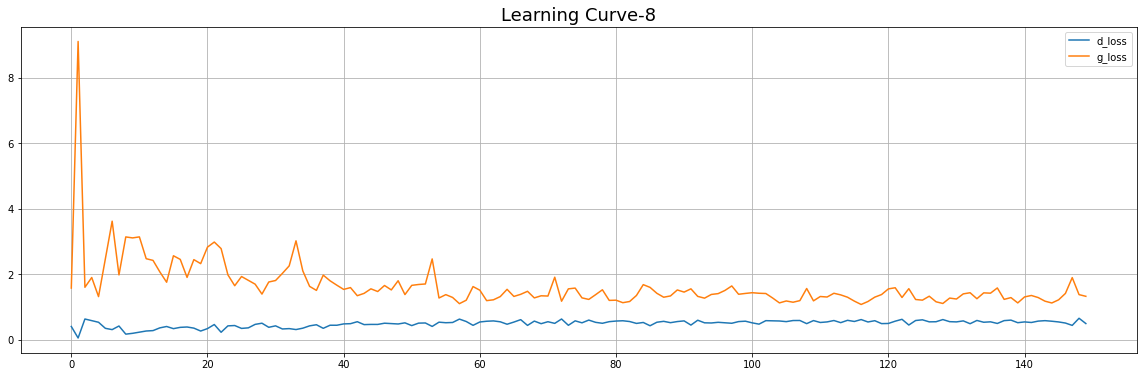

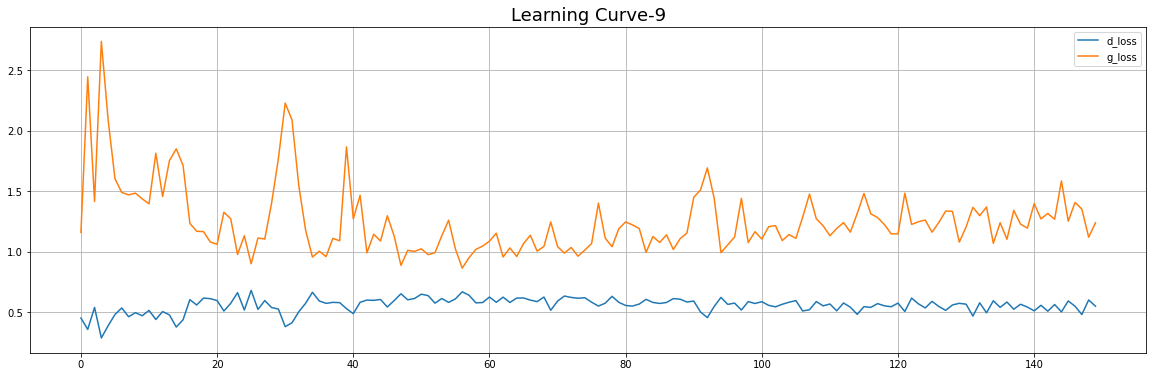

In [9]:
for i in range(10):
    LABEL = i
    dataset = prepare_data(LABEL, BATCH_SIZE)

    generator = build_generator()
    discriminator = build_discriminator()
    
    gan = DCGAN(
        discriminator=discriminator, generator=generator, 
        latent_dim=CODINGS_SIZE
    )
    gan.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss_fn=keras.losses.BinaryCrossentropy(),
    )
    
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.set_title(f'Learning Curve-{LABEL}', fontsize=18)
    history = gan.fit(dataset, epochs=N_EPOCHS, verbose=1)
    pd.DataFrame(history.history).plot(ax=ax)
    ax.grid()
       
    generator.save(f'MNIST-AUG-DCGAN-{LABEL}.h5')

# Generated Images

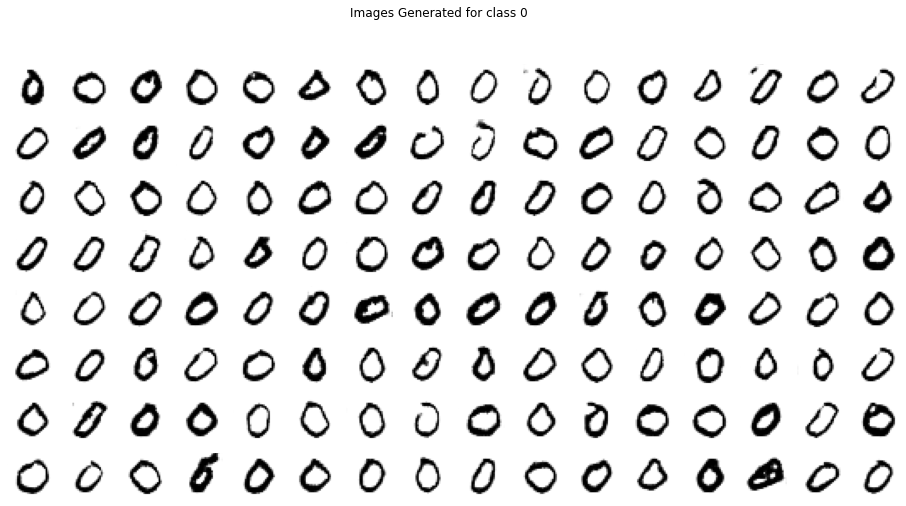

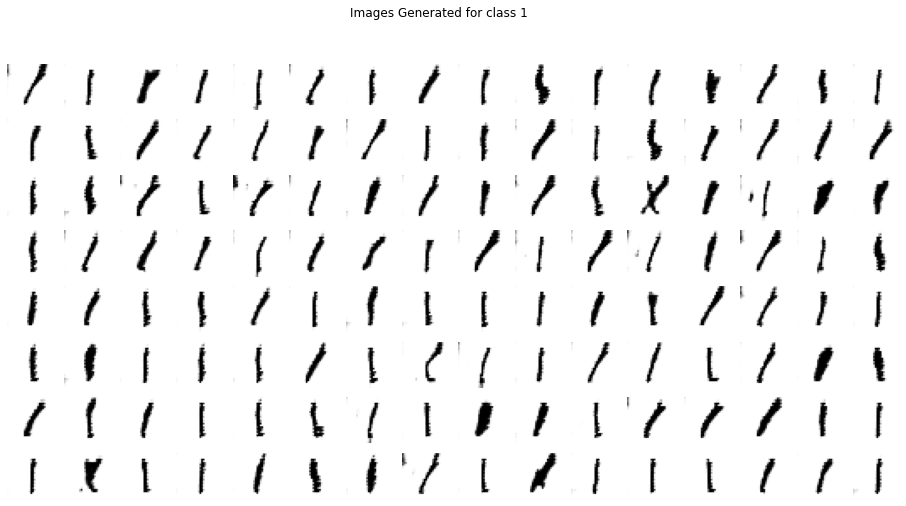

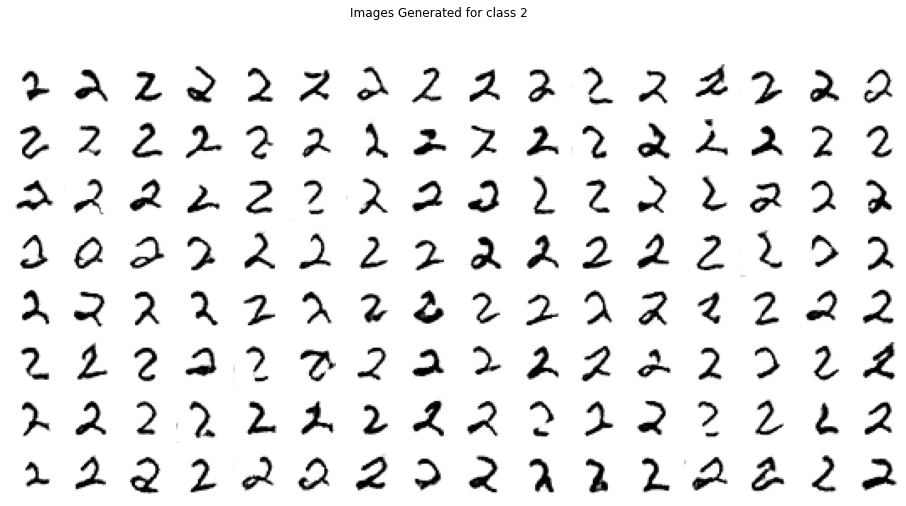

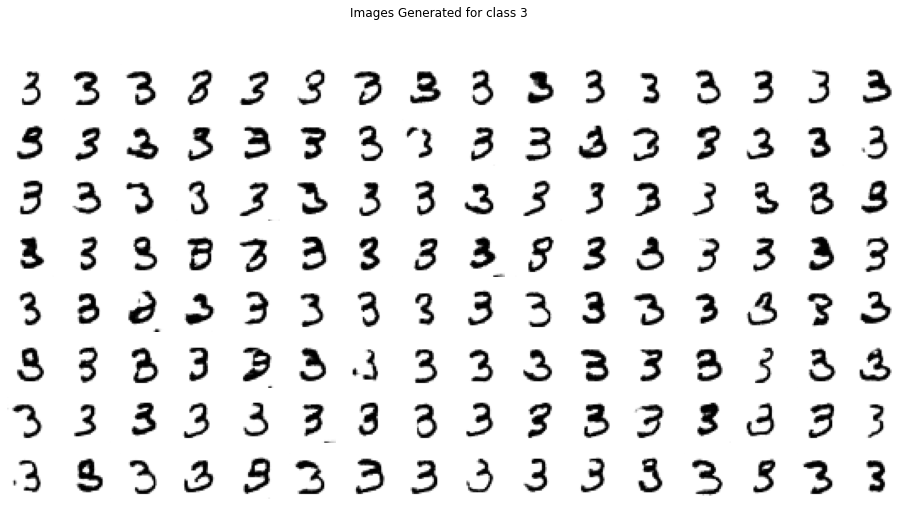

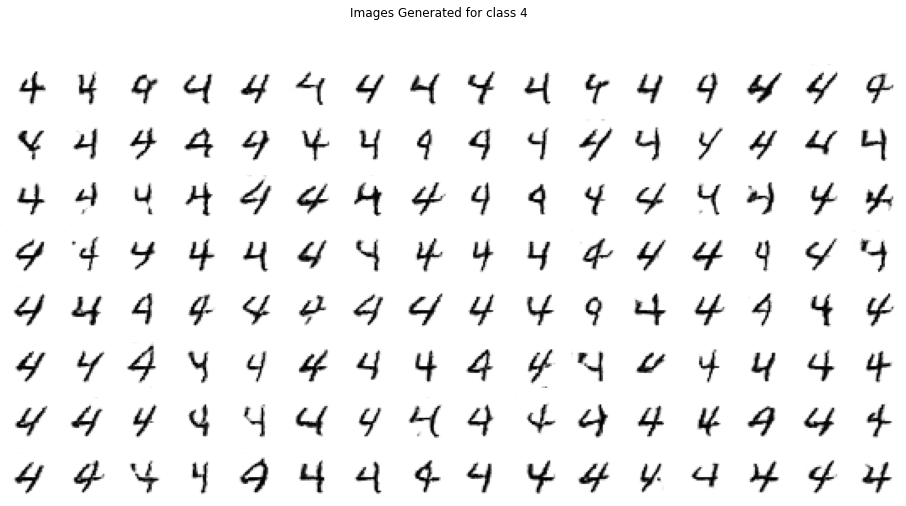

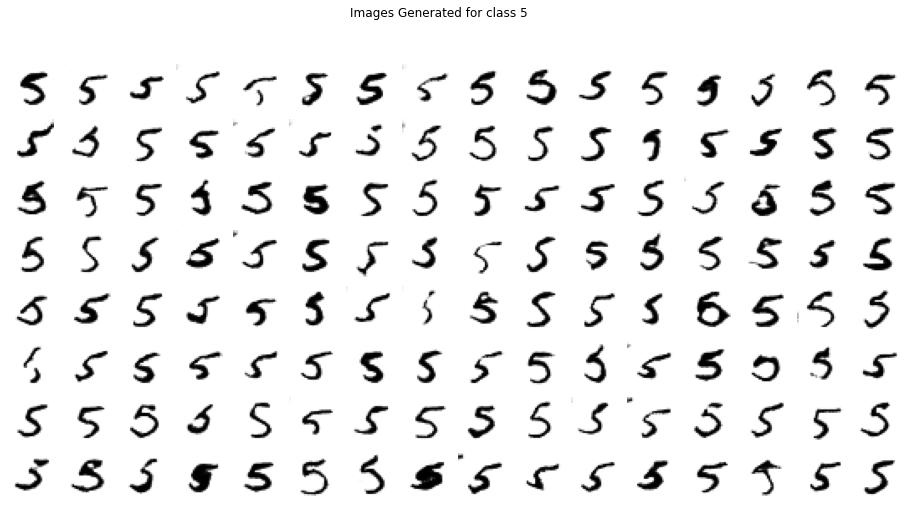

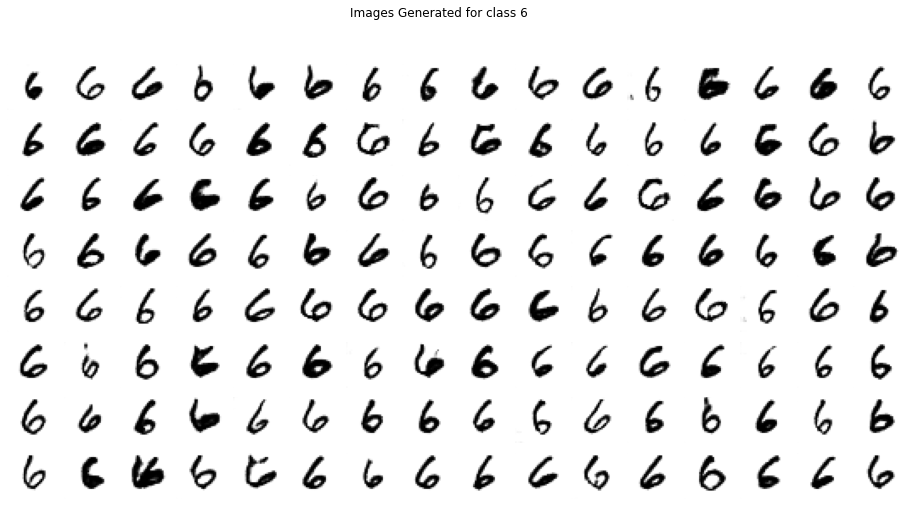

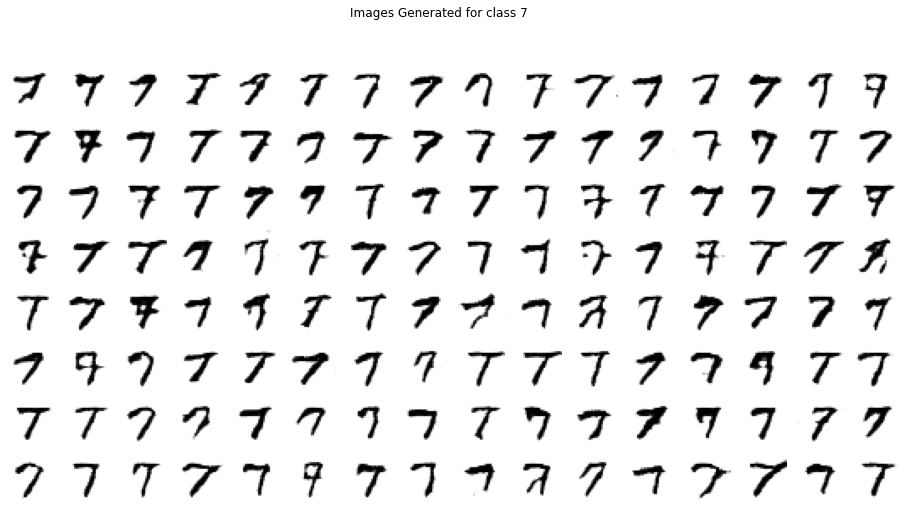

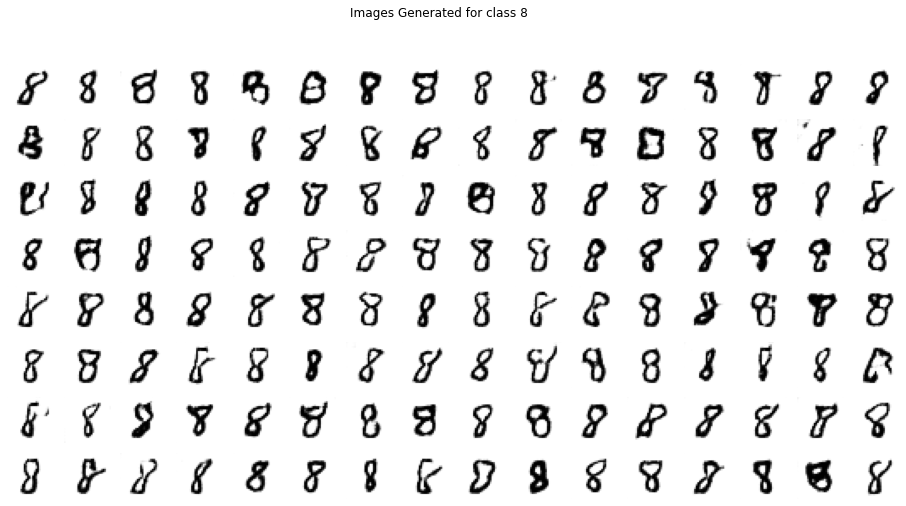

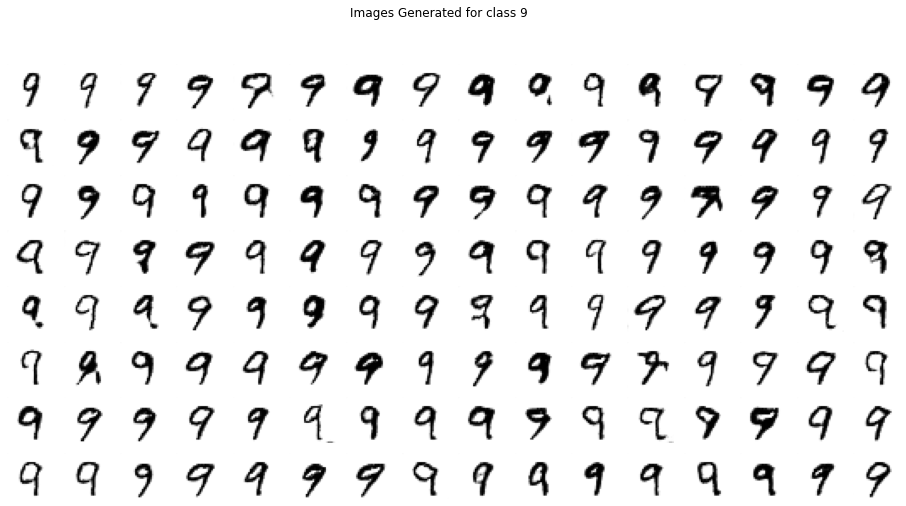

In [10]:
from scipy.linalg import sqrtm

def frechet_distance(act1, act2):
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

evaluator = keras.models.Sequential(keras.models.load_model('../input/mnist-net/mnist_net.h5').layers[:-1])
scores = []

for i in range(10):
    generator = keras.models.load_model(f'MNIST-AUG-DCGAN-{i}.h5')
    fake_images = generator(tf.random.normal([128, CODINGS_SIZE]))
    embeddings_real = evaluator(prepare_images(i))
    embeddings_fake = evaluator(fake_images)
    scores.append(frechet_distance(embeddings_real, embeddings_fake))
    plot_results(fake_images, 16, f'Images Generated for class {i}')
    plt.show()

# Evaluation

In [11]:
pd.Series(scores, name="Frechet Distance")

0    33.578593
1    57.350237
2    26.242046
3    19.329678
4    27.092144
5    20.969034
6    40.230452
7    17.374510
8    29.219072
9    23.431041
Name: Frechet Distance, dtype: float64